In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DateType, FloatType, IntegerType, TimestampType, ArrayType, StructType, StructField
from pyspark.sql.functions import from_unixtime, sum, rank,lag, explode, expr,spark_partition_id, to_date, coalesce, lit, to_timestamp, col, month, concat, count, max, when, dayofweek, datediff,dense_rank, desc, date_format
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec,HashingTF,IDF, CountVectorizer,VectorAssembler
from pyspark.sql.functions import udf
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF
from pyspark.ml import Pipeline,PipelineModel
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import LemmatizerModel
from pyspark.ml.classification import LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import sparknlp
import warnings
from google.cloud import storage
from pyspark.sql.functions import from_unixtime, to_date

In [2]:
spark = SparkSession.builder.appName('ml').getOrCreate()
stoarge_client = storage.Client()
# Get the context of the Pyspark environment
spark.sparkContext.getConf().getAll()
# Store spark context as a variable
sc = spark.sparkContext

In [3]:
reddit_data_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group2_Final_Project/reddit_data/",header=True, inferSchema=True)



In [4]:
reddit_data_df.show()

+--------+---------------+---------------+--------------------+------------+----------------+-----------+------+------+-------+--------+------+----------+----------+---------+------------+-----+------------+-----------------------+--------------+---------------------+
|archived|         author|author_fullname|                body|comment_type|controversiality|created_utc|edited|gilded|     id| link_id|locked|      name| parent_id|permalink|retrieved_on|score|subreddit_id|subreddit_name_prefixed|subreddit_type|total_awards_received|
+--------+---------------+---------------+--------------------+------------+----------------+-----------+------+------+-------+--------+------+----------+----------+---------+------------+-----+------------+-----------------------+--------------+---------------------+
|    True|      [deleted]|           null|           [deleted]|        null|               0| 1202444767| False|     0|c034h6g|t3_681ua|  null|t1_c034h6g|  t3_681ua|     null|  1425828031|    1

In [5]:
comment_type_counts = reddit_data_df.groupBy("subreddit_name_prefixed").count()

comment_type_data = comment_type_counts.collect()




comment_types = [row['subreddit_name_prefixed'] for row in comment_type_data]
counts = [row['count'] for row in comment_type_data]



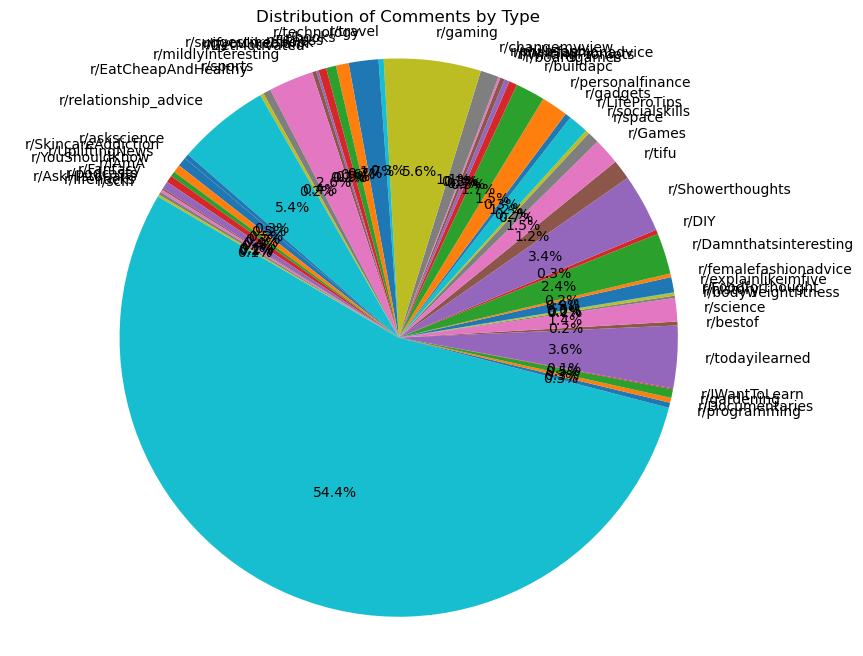

In [6]:
# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=comment_types, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Distribution of Comments by Type')
plt.show()


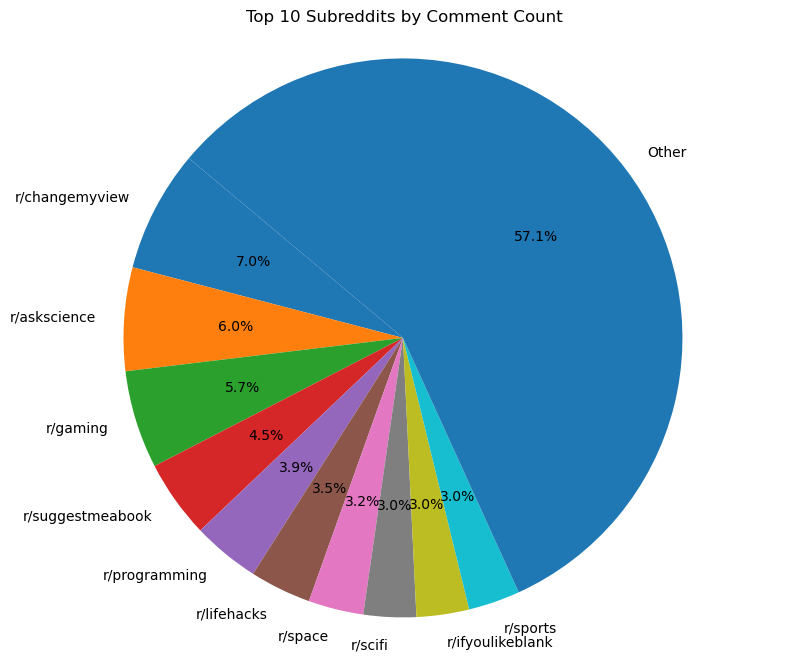

In [10]:
sorted_data = sorted(zip(comment_types, counts), key=lambda x: x[1], reverse=True)
top_comment_types = [x[0] for x in sorted_data[:10]]
top_counts = [x[1] for x in sorted_data[:10]]

# Sum the counts for the 'Other' category using Python's built-in sum function
other_count = __builtins__.sum(x[1] for x in sorted_data[10:])
if other_count > 0:
    top_comment_types.append('Other')
    top_counts.append(other_count)

# Plot the pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_counts, labels=top_comment_types, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Top 10 Subreddits by Comment Count')
plt.show()

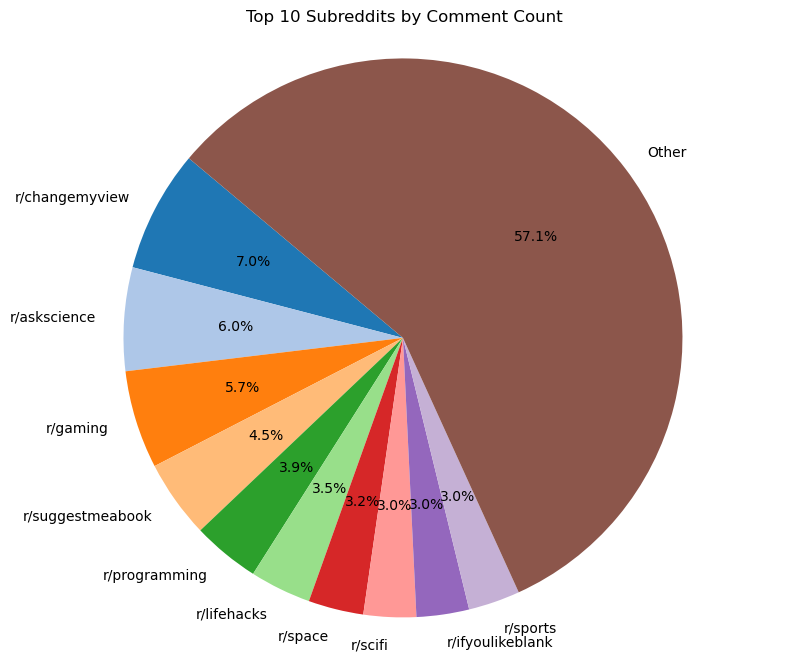

In [13]:
sorted_data = sorted(zip(comment_types, counts), key=lambda x: x[1], reverse=True)
top_comment_types = [x[0] for x in sorted_data[:10]]
top_counts = [x[1] for x in sorted_data[:10]]

# Sum the counts for the 'Other' category using Python's built-in sum function
other_count = __builtins__.sum(x[1] for x in sorted_data[10:])
if other_count > 0:
    top_comment_types.append('Other')
    top_counts.append(other_count)

# Define colors for the slices, 'Other' as gray and the rest with default colors
colors = list(plt.cm.tab20.colors)  # Convert to list to make it mutable
if len(colors) < len(top_counts):
    # If there are more categories than colors, extend the colors list
    colors = colors * (len(top_counts) // len(colors) + 1)
colors[-1] = 'gray'  # Set the last color, which corresponds to 'Other', to gray

# Plot the pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_counts, labels=top_comment_types, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Top 10 Subreddits by Comment Count')
plt.show()

In [29]:
comment_type_counts.show()

+--------------+---------+
|subreddit_type|    count|
+--------------+---------+
|          null|262688681|
|        public|329566465|
|    restricted|   193432|
+--------------+---------+



In [30]:
from pyspark.sql.functions import from_unixtime, to_date

Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6800 ticks ([12898.0, ..., 19697.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to genera

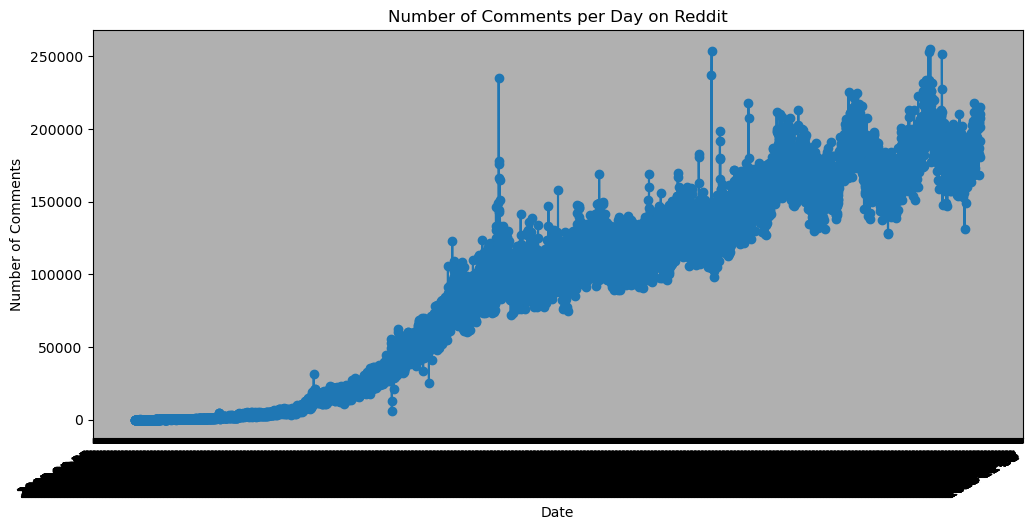

In [7]:
reddit_data_df = reddit_data_df.withColumn('date', to_date(from_unixtime('created_utc')))

# Group by date and count the number of comments
comments_per_day = reddit_data_df.groupBy('date').count().orderBy('date')
time_series_data = comments_per_day.collect()

import matplotlib.dates as mdates

# Extracting dates and counts
dates = [row['date'] for row in time_series_data]
counts = [row['count'] for row in time_series_data]

# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(dates, counts, marker='o', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.title('Number of Comments per Day on Reddit')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.show()

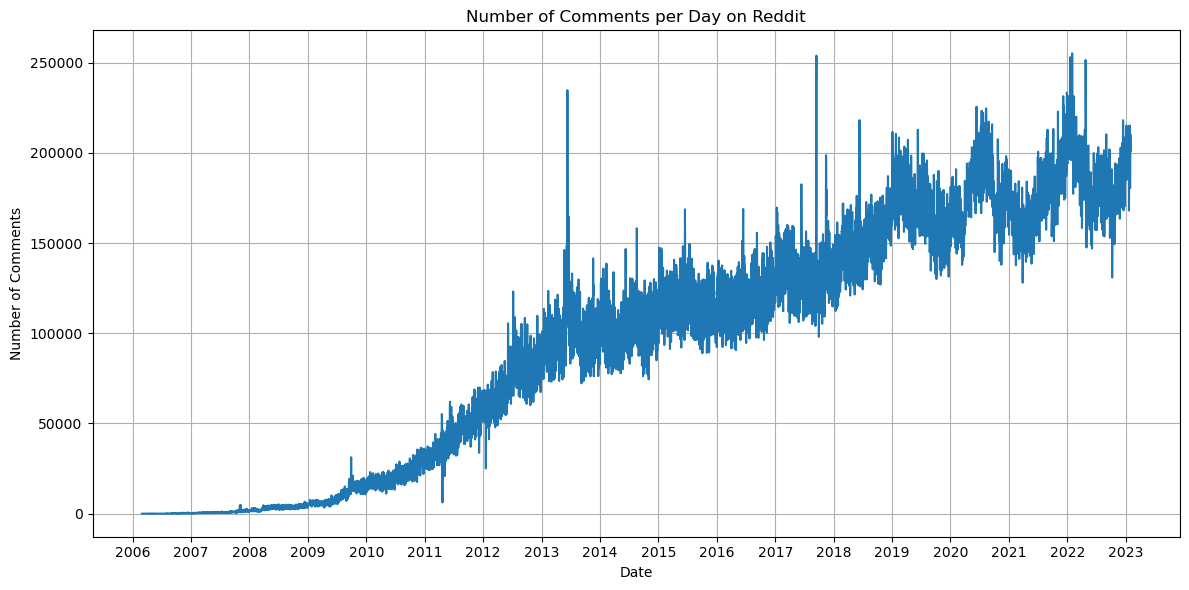

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(dates, counts, linestyle='-')
#, marker='o'
# Set the x-axis major locator to year and formatter to just the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Remove any minor ticks
plt.gca().xaxis.set_minor_locator(mdates.AutoDateLocator())

plt.title('Number of Comments per Day on Reddit')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

In [37]:
from pyspark.sql.functions import to_date, from_unixtime

# Convert 'created_utc' to a date format and group by this date
reddit_data_df = reddit_data_df.withColumn('date', to_date(from_unixtime('created_utc')))
comments_per_day = reddit_data_df.groupBy('date').count().orderBy('date')

# Collect the data again
time_series_data = comments_per_day.collect()

# Now we expect 'dates' and 'counts' to be aligned
dates = [row['date'] for row in time_series_data]
counts = [row['count'] for row in time_series_data]

# Verify the lengths again
print(f"Length of dates: {len(dates)}")
print(f"Length of counts: {len(counts)}")

Length of dates: 6182
Length of counts: 6182


In [39]:
comment_type_counts.write.csv('gs://msca-bdp-student-gcs/Group2_Final_Project/visual/comment_type_counts.csv', header=True)